<a href="https://colab.research.google.com/github/Nyandwi/tf_vision/blob/main/Horse_and_Human_Classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Horse and Human Classifier

In the demo, we saw how traditional programming is not so effective at solving complex problems, particularly because we have to define all the rules which are not expressive when it comes to computer vision. How would you write a code for that hard expressions? 

This is why we are turning into machine learning. Instead of hardcoding the rules of what differentiate a human to a horse, why not just feed the bunch of images of both to the model and get done with that? 

This is exactly what you will do here, and at the end you will load the images to make predictions for yourself. We will use a horse and human dataset created by Laurence Moroney, 
Developer Lead at Google.

## Loading and Preprocessing Data

In [ ]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip \
    -O /tmp/horse-or-human.zip

!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip \
    -O /tmp/validation-horse-or-human.zip

--2021-04-12 11:04:36--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.142.128, 74.125.195.128, 74.125.20.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.142.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 149574867 (143M) [application/zip]
Saving to: ‘/tmp/horse-or-human.zip’

/tmp/horse-or-human 100%[===================>] 142.65M   114MB/s    in 1.2s    

2021-04-12 11:04:37 (114 MB/s) - ‘/tmp/horse-or-human.zip’ saved [149574867/149574867]

--2021-04-12 11:04:37--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/validation-horse-or-human.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.20.128, 74.125.142.128, 74.125.195.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.20.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 114801

The code below will use the OS library to use Operating System libraries to unzip the data.

In [ ]:
import os
import zipfile

local_zip = '/tmp/horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/horse-or-human')
local_zip = '/tmp/validation-horse-or-human.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/validation-horse-or-human')
zip_ref.close()

The contents of the .zip are extracted to the base directory /tmp/horse-or-human, which in turn each contain horses and humans subdirectories.

In this case, we do not explicitly label the images as horses or humans. If you remember with the fashion example earlier, we had labelled 'this is a 1', 'this is a 7' etc.

Later you'll see something called an ImageGenerator being used -- and this is coded to read images from subdirectories, and automatically label them from the name of that subdirectory. For example, you will have a 'training' directory containing a 'horses' directory and a 'humans' one. ImageGenerator will label the images appropriately for you, reducing a coding step.
Let's define each of these directories:

In [ ]:
# Directory with our training horse pictures
train_horse_dir = os.path.join('/tmp/horse-or-human/horses')

# Directory with our training human pictures
train_human_dir = os.path.join('/tmp/horse-or-human/humans')

# Directory with our training horse pictures
validation_horse_dir = os.path.join('/tmp/validation-horse-or-human/horses')

# Directory with our training human pictures
validation_human_dir = os.path.join('/tmp/validation-horse-or-human/humans')

Let's see what the filenames look like in the horses and humans training directories.

In [ ]:
train_horse_names = os.listdir(train_horse_dir)
print(train_horse_names[:5])

print('############')

train_human_names = os.listdir(train_human_dir)
print(train_human_names[:5])

['horse37-2.png', 'horse39-0.png', 'horse43-7.png', 'horse32-8.png', 'horse36-8.png']
############
['human06-17.png', 'human11-19.png', 'human10-14.png', 'human03-11.png', 'human12-17.png']


The following is the total number of horse and human images in the directories

In [ ]:
print('total training horse images:', len(os.listdir(train_horse_dir)))
print('total training human images:', len(os.listdir(train_human_dir)))

total training horse images: 500
total training human images: 527


Let's visualize few pictures to get a better sense of what they look like.

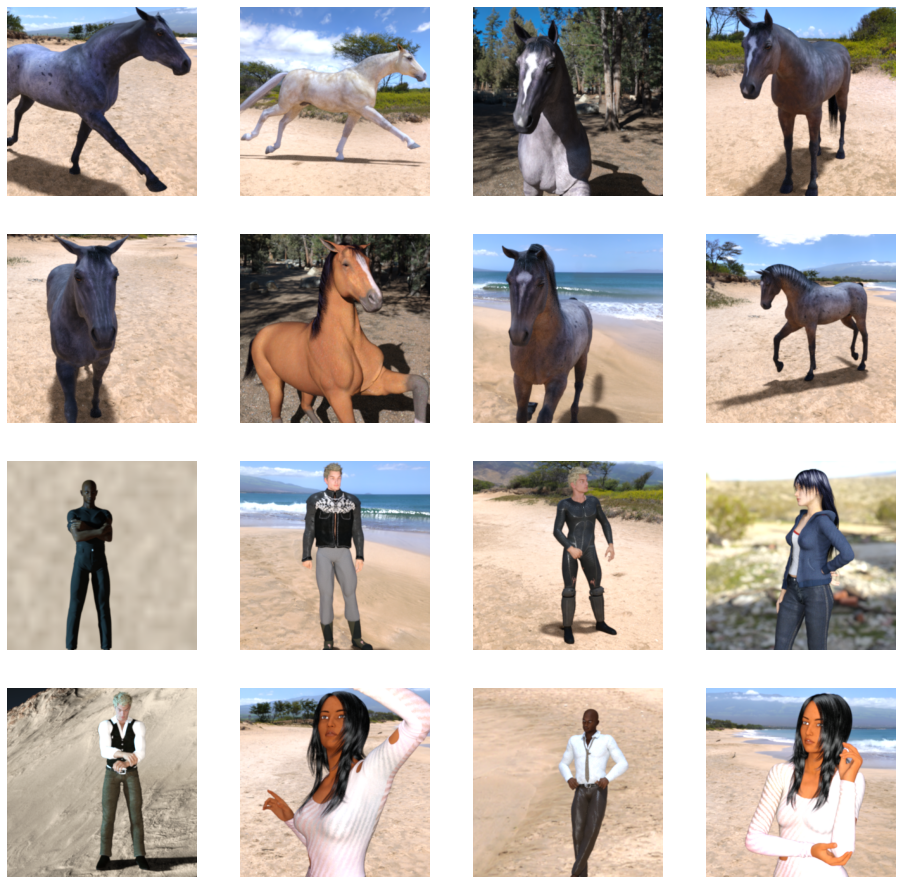

In [ ]:
%matplotlib inline

import matplotlib.pyplot as plt
import matplotlib.image as mpimg

# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4

# Index for iterating over images
pic_index = 0


# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)

pic_index += 8
next_horse_pix = [os.path.join(train_horse_dir, fname) 
                for fname in train_horse_names[pic_index-8:pic_index]]
next_human_pix = [os.path.join(train_human_dir, fname) 
                for fname in train_human_names[pic_index-8:pic_index]]

for i, img_path in enumerate(next_horse_pix+next_human_pix):
  # Set up subplot; subplot indices start at 1
  sp = plt.subplot(nrows, ncols, i + 1)
  sp.axis('Off') # Don't show axes (or gridlines)

  img = mpimg.imread(img_path)
  plt.imshow(img)

plt.show()

## Data PreProcessing 

We will set up data generators that will read pictures in our source folders, convert them to float32 tensors, and feed them (with their labels) to our network. We'll have one generator for the training images and one for the validation images. Our generators will yield batches of images of size 300x300 and their labels (binary).

Usually, data that goes into neural networks should be normalized in some way to make it more amenable to processing by the network. In our case, we will preprocess our images by normalizing the pixel values to be in the [0, 1] range (originally all values are in the [0, 255] range).


In Keras this can be done via the keras.preprocessing.image.ImageDataGenerator class using the rescale parameter. 

This ImageDataGenerator class allows you to instantiate generators of augmented image batches (and their labels) via .flow(data, labels) or .flow_from_directory(directory). These generators can then be used with the Keras model methods that accept data generators as inputs: fit_generator, evaluate_generator, and predict_generator.

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

##This will rescale images by 1./255

train_datagen=ImageDataGenerator(rescale=1./255)

train_generator=train_datagen.flow_from_directory(

              '/tmp/horse-or-human/', #Source directory of train images
              target_size=(300, 300),
              batch_size=128,

              class_mode='binary') #Since we use binary_crossentropy, two classes


validation_datagen=ImageDataGenerator(rescale=1./255)

validation_generator=validation_datagen.flow_from_directory(

              '/tmp/validation-horse-or-human/', #Source directory of validation images
              target_size=(300, 300),
              batch_size=32,

              class_mode='binary') #Since we use binary__crossentropy, two classes


Found 1027 images belonging to 2 classes.
Found 256 images belonging to 2 classes.


## Building a Model

In [ ]:
import tensorflow as tf

Here is the model that we are going to build:

* Convolutional layers followed by Maxpooling layers 

* Flattening layers to output single dimensional vector

* Dense layers at the end. Since the task at hand is classification of categories, we will use sigmoid activation function. It outputs the probability between 0 and 1 for any input,  encoding the probability that the current image is class 1 (as opposed to class 0).

In [ ]:
model = tf.keras.models.Sequential([
                                    

    tf.keras.layers.Conv2D(16, (3,3), activation='relu', 
                           input_shape=(300, 300, 3)),
    tf.keras.layers.MaxPooling2D(2, 2),



    tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.MaxPooling2D(2,2),


    tf.keras.layers.Flatten(),


    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [ ]:
## Model summary to show the size and the shape of the network

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 298, 298, 16)      448       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 149, 149, 16)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 147, 147, 32)      4640      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 73, 73, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 71, 71, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 35, 35, 64)        0         
_________________________________________________________________
flatten (Flatten)            (None, 78400)             0

Few notes to take from the summary, is that the convolutions layers reduce the size of the feature maps by a bit due to padding, and each pooling layer halves the dimensions. 


Lt's compile the model.

We'll configure the specifications for model training. We will train our model with the `binary_crossentropy` loss, because it's a binary classification problem and our final activation is a sigmoid. (For a refresher on loss metrics, see the [Machine Learning Crash Course](https://developers.google.com/machine-learning/crash-course/descending-into-ml/video-lecture).) We will use the `rmsprop` optimizer with a learning rate of `0.001`. During training, we will want to monitor classification accuracy.

**NOTE**: In this case, using the [RMSprop optimization algorithm](https://wikipedia.org/wiki/Stochastic_gradient_descent#RMSProp) is preferable to [stochastic gradient descent](https://developers.google.com/machine-learning/glossary/#SGD) (SGD), because RMSprop automates learning-rate tuning for us. (Other optimizers, such as [Adam](https://wikipedia.org/wiki/Stochastic_gradient_descent#Adam) and [Adagrad](https://developers.google.com/machine-learning/glossary/#AdaGrad), also automatically adapt the learning rate during training, and would work equally well here.)

In [ ]:
from tensorflow.keras.optimizers import RMSprop

model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

## Model Training 

Let's train for 15 epochs -- this may take a few minutes to run. Make sure you are running on GPU (Choose it from the Runtime...Change Runtime)


Do note the values per epoch.
The Loss and Accuracy are a great indication of progress of training. It's making a guess as to the classification of the training data, and then measuring it against the known label, calculating the result. Accuracy is the portion of correct guesses.

In [ ]:
history = model.fit(
      train_generator,
      validation_data = validation_generator,  
      epochs=15,
      steps_per_epoch=8,
      validation_steps=8,
      verbose=1)

Epoch 1/15
8/8 [==============================] - 41s 879ms/step - loss: 4.0803 - accuracy: 0.4881 - val_loss: 0.6889 - val_accuracy: 0.6445
Epoch 2/15
8/8 [==============================] - 7s 883ms/step - loss: 1.0627 - accuracy: 0.6890 - val_loss: 2.9530 - val_accuracy: 0.6328
Epoch 3/15
8/8 [==============================] - 7s 871ms/step - loss: 0.3538 - accuracy: 0.8372 - val_loss: 1.2025 - val_accuracy: 0.8359
Epoch 4/15
8/8 [==============================] - 7s 929ms/step - loss: 0.1005 - accuracy: 0.9670 - val_loss: 1.7113 - val_accuracy: 0.7930
Epoch 5/15
8/8 [==============================] - 7s 867ms/step - loss: 0.0398 - accuracy: 0.9852 - val_loss: 1.2815 - val_accuracy: 0.8516
Epoch 6/15
8/8 [==============================] - 7s 877ms/step - loss: 0.0472 - accuracy: 0.9851 - val_loss: 1.6815 - val_accuracy: 0.8242
Epoch 7/15
8/8 [==============================] - 7s 875ms/step - loss: 0.0124 - accuracy: 0.9971 - val_loss: 2.0405 - val_accuracy: 0.8242
Epoch 8/15
8/8 [===

## Making Predictions

Let's now take a look at actually running a prediction using the model. This code will allow you to choose 1 or more files from your file system, it will then upload them, and run them through the model, giving an indication of whether the object is a horse or a human.

You can download images from the internet to your file system to try them out! 

Note that you might see that the network makes a LOT of mistakes, despite the fact that the training accuracy is above 99%.

This is due to something called **overfitting**, which means that the neural network is trained with very limited data -- there are only 500ish images of each class. So it's very good at recognizing images that look like those in the training set, but it can fail a lot at images that are not in the training set.

This is a data point proving that the more data you train on, the better your final network will be!

There are many techniques that can be used to make your training better, despite limited data, including something called Image Augmentation. That's beyond the scope of this lab!

In [ ]:
import numpy as np
from google.colab import files
from keras.preprocessing import image

uploaded = files.upload()

for fn in uploaded.keys():
 
  # predicting images
  path = '/content/' + fn
  img = image.load_img(path, target_size=(300, 300))
  x = image.img_to_array(img)
  x = x / 255
  x = np.expand_dims(x, axis=0)
  images = np.vstack([x])
  classes = model.predict(images, batch_size=10)
  print(classes[0])
  
  if classes[0]>0.5:
    print(fn + " is a human")
  else:
    print(fn + " is a horse")


### This was long but exciting as well. 